In [ ]:
# default_exp tabular.learner

# learner

> API details.

In [ ]:
#export
from fastai.torch_basics import *
from fastai.data.all import *
from fastai.tabular.data import *
from fastai.tabular.core import *
from fastai.tabular.model import *
from fastrenewables.tabular.core import *
from fastrenewables.tabular.data import *
from fastrenewables.tabular.model import *
from fastai.basics import *


In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
#export
class RenewableLearner(Learner):
    "`Learner` for renewable data"
    def predict(self, ds_idx=1, test_dl=None, filter=True):
        device = next(learn.model.parameters()).device
        
        if test_dl is not None:
            cur_dl = test_dl
        elif ds_idx == 0:
            cur_dl = self.dls.train_ds
        elif ds_idx == 1:
            cur_dl = self.dls.valid_ds
            
        if type(cur_dl) == TabularPandas or \
            type(cur_dl) == TabDataLoader or \
            type(cur_dl) == TabularRenewables:
                
            cats = tensor(
                cur_dl.cats.values,
            ).long()
            xs = tensor(cur_dl.conts.values)
            targets = tensor(cur_dl.y.values)
        
        with torch.no_grad():
            preds = learn.model(cats.to(device), xs.to(device))
        
        preds, targets = to_np(preds).reshape(-1), to_np(targets).reshape(-1)
        if filter:
            preds[preds < 0] = 0
            preds[preds > 1.1] = 1.1
            
        return preds, targets

In [ ]:
show_doc(RenewableLearner, title_level=3)

<h3 id="RenewableLearner" class="doc_header"><code>class</code> <code>RenewableLearner</code><a href="" class="source_link" style="float:right">[source]</a></h3>

> <code>RenewableLearner</code>(**`dls`**, **`model`**, **`loss_func`**=*`None`*, **`opt_func`**=*`Adam`*, **`lr`**=*`0.001`*, **`splitter`**=*`trainable_params`*, **`cbs`**=*`None`*, **`metrics`**=*`None`*, **`path`**=*`None`*, **`model_dir`**=*`'models'`*, **`wd`**=*`None`*, **`wd_bn_bias`**=*`False`*, **`train_bn`**=*`True`*, **`moms`**=*`(0.95, 0.85, 0.95)`*) :: `Learner`

`Learner` for renewable data

In [ ]:
cont_names = ['T_HAG_2_M', 'RELHUM_HAG_2_M', 'PS_SFC_0_M', 'ASWDIFDS_SFC_0_M',
       'ASWDIRS_SFC_0_M', 'WindSpeed58m']
cat_names = ['TaskID', 'Month', 'Day', 'Hour']
pd.options.mode.chained_assignment=None
dls = RenewableDataLoaders.from_files(glob.glob("../data/*.h5"), y_names="PowerGeneration", 
                                      pre_procs=[FilterYear(year=2020), AddSeasonalFeatures], 
                                      cat_names=cat_names, cont_names=cont_names)

{'y_names': 'PowerGeneration', 'pre_procs': [FilterYear -- {}:
encodes: (object,object) -> encodes
decodes: , <class 'fastrenewables.tabular.core.AddSeasonalFeatures'>], 'cat_names': ['TaskID', 'Month', 'Day', 'Hour'], 'cont_names': ['T_HAG_2_M', 'RELHUM_HAG_2_M', 'PS_SFC_0_M', 'ASWDIFDS_SFC_0_M', 'ASWDIRS_SFC_0_M', 'WindSpeed58m']}


In [ ]:

def get_structure(
    initial_size,
    percental_reduce,
    min_value,
    input_size=None,
    final_outputs=1,
    reverse_structure=False,
):
    """
    Turn the given parameters into the structure of an ann model.

    The 'initial size' acts as the first layer, and each following layer i is of the size
    'initial_size' * (1 - percental_reduce) ^ i. This is repeated until 'min_value' is reached. Finally, 'final_outputs'
    is appended as the last layer.

    Parameters
    ----------
    initial_size : integer
        size of the first layer, and baseline for all following layers.
    percental_reduce : float
        percentage of the size reduction of each subsequent layer.
    min_value : integer
        the minimum layer size up to which the 'initial_size' is used to create new layers.
    input_size : integer
        if not None, a layer of the given size will be prepended to the actual structure.
    final_outputs : integer
        the size of the final layer.

    Returns
    -------
    list
        The finished structure of the ann model.
    """
    ann_structure = [initial_size]
    final_outputs = listify(final_outputs)

    if 0 in final_outputs or (None in final_outputs):
        raise ValueError(
            "Invalid parameters: final_outputs should not contain 0 or None"
        )

    if percental_reduce >= 1.0:
        percental_reduce = percental_reduce / 100.0

    while True:
        new_size = int(ann_structure[-1] - ann_structure[-1] * percental_reduce)

        if new_size <= min_value:
            new_size = min_value
            ann_structure.append(new_size)
            break
        else:
            ann_structure.append(new_size)

    if reverse_structure:
        ann_structure = list(reversed(ann_structure))

    if input_size != None:
        input_size = listify(input_size)
        return input_size + ann_structure + final_outputs

    else:
        return ann_structure + final_outputs

In [ ]:
#export
@delegates(Learner.__init__)
def renewable_learner(dls, layers=None, emb_szs=None, config=None, n_out=None, y_range=None, embedding_type=EmbeddingType.Normal, **kwargs):
    "Get a `Learner` using `dls`, with `metrics`, including a `TabularModel` created using the remaining params."
    if config is None: config = tabular_config()
    
    to = dls.train_ds
    emb_szs = get_emb_sz(dls.train_ds, {} if emb_szs is None else emb_szs)
    if n_out is None: n_out = get_c(dls)
    assert n_out, "`n_out` is not defined, and could not be inferred from data, set `dls.c` or pass `n_out`"
    
    if layers is None: layers = [len(dls.cont_names), 200, 100, n_out]
    if y_range is None and 'y_range' in config: y_range = config.pop('y_range')
        
    embed_p = kwargs["embed_p"].pop() if "embed_p" in kwargs.keys() else 0.1
    
        
    if emb_szs is not None:
        emb_module = EmbeddingModule(None, embedding_dropout=embed_p, embedding_dimensions=emb_szs)
        
    model = MultiLayerPerceptron(layers, embedding_module=emb_module, **config)
    
#     TODO add bayesian loss
    
    return RenewableLearner(dls, model, **kwargs)




In [ ]:
learn = renewable_learner(dls, metrics=rmse)

In [ ]:
dls.show_batch()

,TaskID,Month,Day,Hour,T_HAG_2_M,RELHUM_HAG_2_M,PS_SFC_0_M,ASWDIFDS_SFC_0_M,ASWDIRS_SFC_0_M,WindSpeed58m,PowerGeneration
0,1,1,12,4,275.239,94.732,98444.987996,8.857000,0.402002,5.183627,0.120
1,2,12,9,22,274.464,89.597,93273.914000,26.894999,6.605003,9.835812,0.059
2,1,3,19,14,280.551,45.188,99153.668032,58.413000,124.918998,2.478674,0.005
3,1,11,20,13,278.050,74.106,97975.293000,33.861000,21.382998,3.012120,0.006
4,1,11,23,23,274.746,96.752,96840.987959,31.107000,17.617000,2.479837,0.003
5,2,9,27,13,288.006,81.087,93218.487998,51.687000,19.365000,8.374600,0.694
6,1,11,8,14,280.142,78.493,96982.261978,46.122000,13.926002,3.967423,0.017
7,0,12,13,3,275.120,87.620,96705.414034,18.381000,9.586001,5.652658,0.093
8,0,4,1,10,283.121,51.852,100964.770004,48.083000,140.133999,4.822452,0.002
9,2,8,10,19,290.569,84.564,93763.288997,104.109999,128.206000,3.636913,0.017


In [ ]:
learn.model

MultiLayerPerceptron(
  (embedding_module): EmbeddingModule(
    (embeddings): ModuleList(
      (0): Embedding(4, 3)
      (1): Embedding(13, 7)
      (2): Embedding(32, 11)
      (3): Embedding(25, 10)
    )
    (emb_drop): Dropout(p=0.1, inplace=False)
  )
  (final_activation): Identity()
  (embeds): ModuleList()
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): BatchNorm1d(37, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Linear(in_features=37, out_features=200, bias=False)
      (2): ReLU(inplace=True)
    )
    (1): LinBnDrop(
      (0): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Linear(in_features=200, out_features=100, bias=False)
      (2): ReLU(inplace=True)
    )
    (2): LinBnDrop(
      (0): Linear(in_features=100, out_features=1, bias=True)
    )
  )
)

In [ ]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,_rmse,time
0,0.015541,0.013574,0.116507,00:03


In [ ]:
n_conts=len(dls.cont_names)
hidden_layers = [n_conts] + get_structure(n_conts*20,90,10)
learn = renewable_learner(dls, metrics=rmse, layers=hidden_layers, embedding_type=EmbeddingType.Bayes)

In [ ]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,_rmse,time
0,0.013593,0.013329,0.115451,00:03


In [ ]:
preds,target = learn.predict()

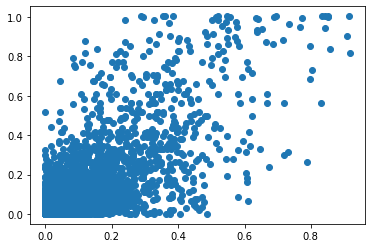

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(preds,target)

In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted 00_tabular.core.ipynb.
Converted 01_tabular.data.ipynb.
Converted 02_tabular.model.ipynb.
Converted 03_tabular.learner.ipynb.
Converted index.ipynb.
